#                             FLIGHT TAKE OFF DATA

This data is about flights leaving from JKF ariport between Nov 2019-Dec-2020. Taxi-Out prediction has been an important concept as it helps in calculating Runway time and directly impact the cost of the flight.
About the data 
* Month = 1-12
* Day_of_onth= 1-31
* Day_Of_Week= 1 (Monday) - 7 (Sunday)
* Dep_Time_M =actual departure time (local, hhmm)
* CRS_Dep_M =scheduled departure time (local, hhmm)
* sch_Arr =actual arrival time (local, hhmm)
* CRS_Arr_m= scheduled arrival time (local, hhmm)
* op_unique_Carrier= unique carrier code
  "B6" "DL" "AA" "AS" "MQ" "9E" "YX" "HA" "OO"
* Tail_Num =plane tail number
* Wind = Direction
* Wind speed = In num
* Tempratue =in celcius
* Pressure
* humidity 
* Arr_Delay =Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers, in minutes
* Dep_Delay =Difference in minutes between scheduled and actual departure time. Early departures show negative numbers, in minutes
* Dest= destination IATA airport code
* Distance =Distance between airports (miles)
* TaxiOut(Y Dependent Var)= The time elapsed between departure from the origin airport gate and wheels off, in minutes

In [1]:
library(caTools)#for splitting
library(CatEncoders) # label & one hot encoding
library(lmtest) 
library(e1071)# For svr model
library(Metrics)
library(caret)
library(car)
library(dummies)
library(superml)


library(readr)
M1 <- read_csv("../input/transformed-m1/M1_final.csv")
summary(M1)
ls(M1)



Attaching package: ‘CatEncoders’


The following object is masked from ‘package:base’:

    transform


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following objects are masked from ‘package:Metrics’:

    precision, recall


The following object is masked from ‘package:httr’:

    progress


Loading required package: carData

dummies-1.5.6 provided by Decision Patterns


Loading required package: R6


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  OP_UNIQUE_CARRIER = col_character(),
  TAIL_NUM = col_character(),
  DEST = col_character(),
  Wind = col_character(),
  Condition = col_character()
)
ℹ Use `spec()` for the full column specifications.




     MONTH         DAY_OF_MONTH    DAY_OF_WEEK    OP_UNIQUE_CARRIER 
 Min.   : 1.000   Min.   : 1.00   Min.   :1.000   Length:28820      
 1st Qu.: 1.000   1st Qu.: 8.00   1st Qu.:2.000   Class :character  
 Median :11.000   Median :16.00   Median :4.000   Mode  :character  
 Mean   : 7.894   Mean   :16.02   Mean   :4.009                     
 3rd Qu.:12.000   3rd Qu.:24.00   3rd Qu.:6.000                     
 Max.   :12.000   Max.   :31.00   Max.   :7.000                     
   TAIL_NUM             DEST             DEP_DELAY        CRS_ELAPSED_TIME
 Length:28820       Length:28820       Min.   : -22.000   Min.   : 57.0   
 Class :character   Class :character   1st Qu.:  -6.000   1st Qu.:124.0   
 Mode  :character   Mode  :character   Median :  -3.000   Median :188.0   
                                       Mean   :   6.375   Mean   :225.3   
                                       3rd Qu.:   2.000   3rd Qu.:365.0   
                                       Max.   :1276.000   Max.   :6

[1] "Condition"         "CRS_ARR_M"         "CRS_DEP_M"        
 [4] "CRS_ELAPSED_TIME"  "DAY_OF_MONTH"      "DAY_OF_WEEK"      
 [7] "DEP_DELAY"         "DEP_TIME_M"        "DEST"             
[10] "Dew Point"         "DISTANCE"          "Humidity"         
[13] "MONTH"             "OP_UNIQUE_CARRIER" "Pressure"         
[16] "sch_arr"           "sch_dep"           "TAIL_NUM"         
[19] "TAXI_OUT"          "Temperature"       "Wind"             
[22] "Wind Gust"         "Wind Speed"

# Splitting Data

In [2]:
split <- sample.split(M1$TAXI_OUT,.90)
train <- subset(M1,split==TRUE)
test <- subset(M1,split==FALSE)
dim(train)
dim(test)


[1] 25938    23

[1] 2882   23

# Label encoding


The data contains NA values. Imputing NA with 'NA' 

The data contains NA values. Imputing NA with 'NA' 



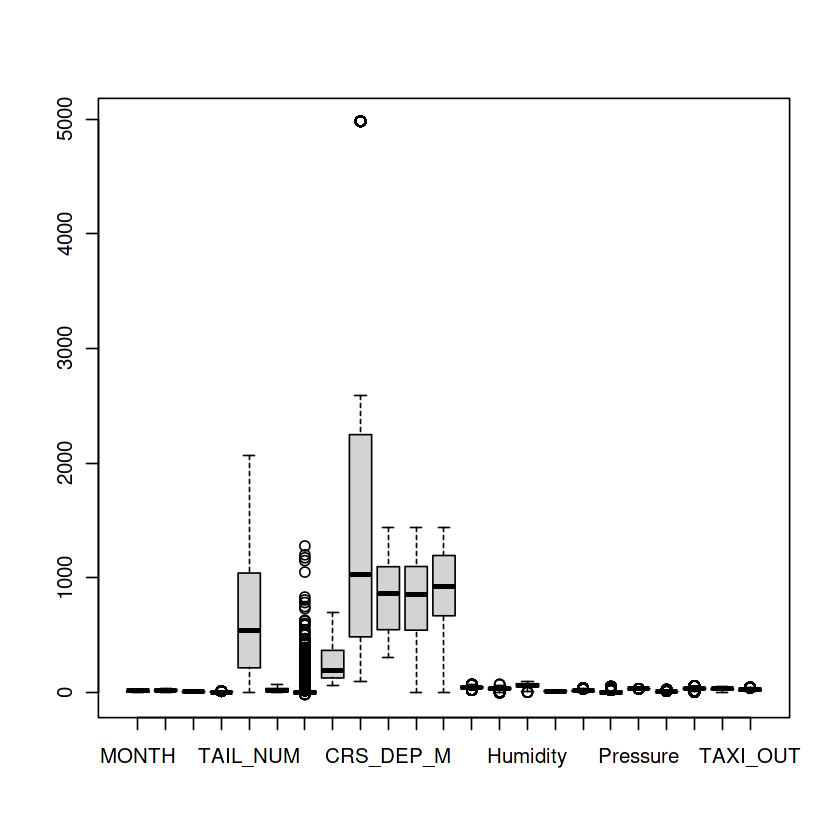

[1] 25846    23

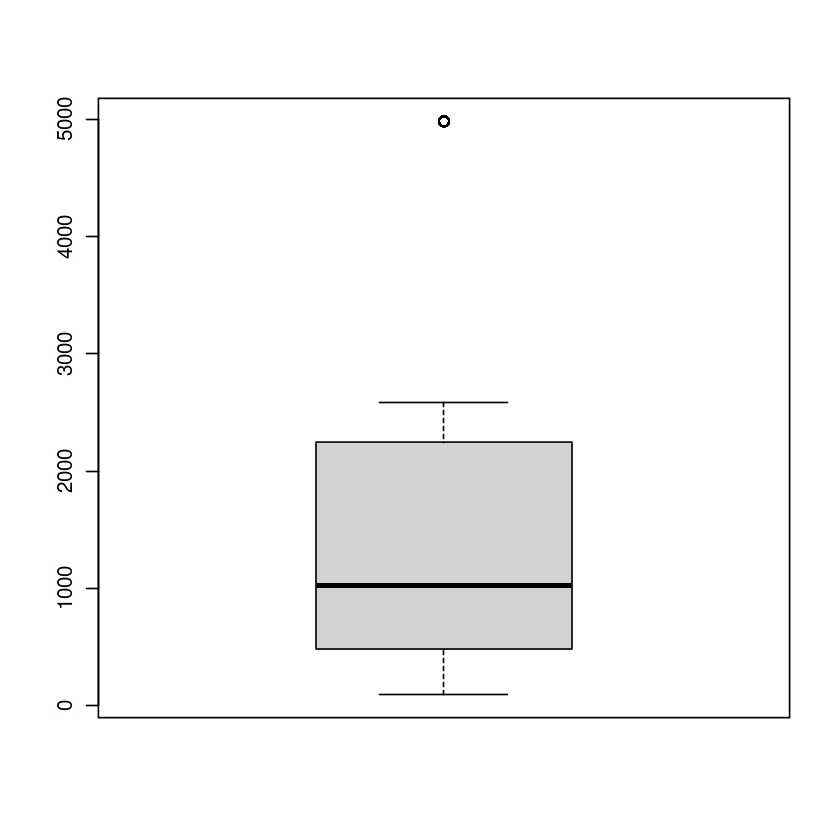

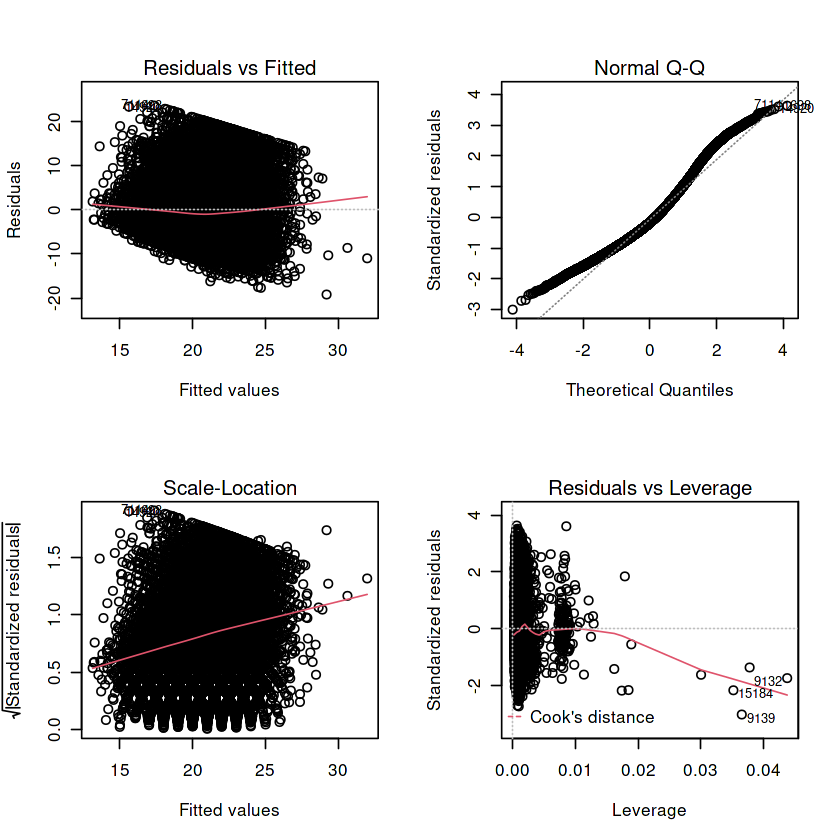

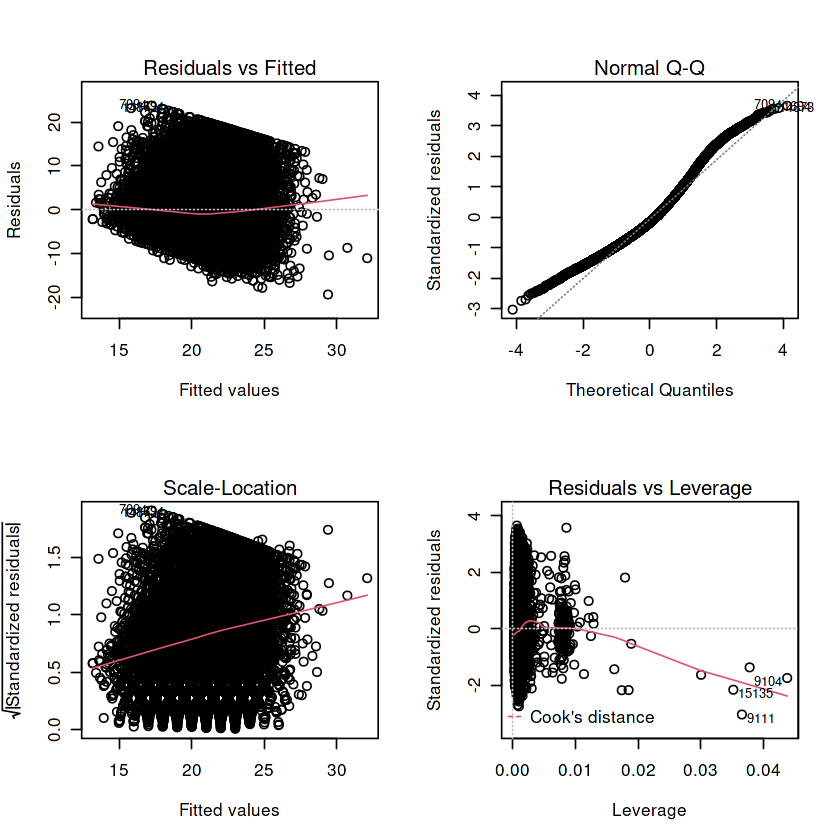

In [3]:

na_cols <- colSums(is.na(train)) / nrow(train)
na_cols <- names(na_cols[which(na_cols > 0.9)])

cat_cols <- names(train)[sapply(train, is.character)]

for(c in cat_cols){
  lbl <- LabelEncoder$new()
  lbl$fit(c(train[[c]], test[[c]]))
  train[[c]] <- lbl$transform(train[[c]])
  test[[c]] <- lbl$transform(test[[c]])
}

# fill missing value with  0
train[is.na(train)] <- 0
test[is.na(test)] <- 0


#boxplot
boxplot(train)
boxplot(train$DISTANCE)
#outliers
Q <- quantile(train$DISTANCE,probs = c(.25,.75),na.rm = TRUE)
iqr <- IQR(train$DISTANCE)
up <-  Q[2]+1.5*iqr # Upper Range  
low<- Q[1]-1.5*iqr # Lower Range﻿
eliminated<- subset(train, train$DISTANCE > (Q[1] - 1.5*iqr) & train$DISTANCE < (Q[2]+1.5*iqr))
dim(eliminated)
#Comparing with and without outliers
X1 <- lm(train$TAXI_OUT~.,data = train)
par(mfrow=c(2,2)) # init 4 charts in 1 panel
plot(X1)
X2 <- lm(eliminated$TAXI_OUT~.,eliminated)
par(mfrow=c(2,2)) # init 4 charts in 1 panel
plot(X2)

#As we can see that there is very less difference between
#after and before removing the outliers and its distance so we keep it


* As we can see that there is very less difference between
* after and before removing the outliers and its distance so we keep it

# Linear Regression with Label encoding



In [4]:
#1linear
lf <- LMTrainer$new(family="gaussian")
lf$fit(X = train, y = "TAXI_OUT")
predictions <- lf$predict(df = test)
r11 <- rmse(actual = test$TAXI_OUT, predicted = predictions)
r11



[1] 6.500136

# Lasso Rigression


In [5]:
#2Lasso regression
lf <- LMTrainer$new(family = "gaussian", alpha = 1, lambda = 1000)
lf$fit(X = train, y = "TAXI_OUT")
predictions <- lf$predict(df = test)
r12 <- rmse(actual = test$TAXI_OUT, predicted = predictions)
r12

[1] 6.499837

# Ridge Regresson


In [6]:
#3ridge regression
lf <- LMTrainer$new(family = "gaussian", alpha=0)
lf$fit(X = train, y = "TAXI_OUT")
predictions <- lf$predict(df = test)
r13 <- rmse(actual = test$TAXI_OUT, predicted = predictions)
r13

[1] 6.518264

# KNN


In [7]:
#4KNN
knn <- KNNTrainer$new(k = 2,prob = T,type = 'reg')
knn$fit(train = train, test = test, y = "TAXI_OUT")
probs <- knn$predict(type = 'prob')
labels <- knn$predict(type='raw')

r14 <- rmse(actual = test$TAXI_OUT, predicted=labels)
r14

[1] 7.907982

# SVR

In [8]:
#5SVR
svm <- svm(train$TAXI_OUT~.,train)
print(svm)
pred <- predict(svm,test)
r15 <- rmse(actual = test$TAXI_OUT, predicted = pred)
r15


Call:
svm(formula = train$TAXI_OUT ~ ., data = train)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.04545455 
    epsilon:  0.1 


Number of Support Vectors:  23471



[1] 6.113588

# Random forest

In [9]:
#6random forest
rf <- RFTrainer$new(n_estimators = 500,classification = 0)
rf$fit(X = train, y = "TAXI_OUT")
pred <- rf$predict(df = test)
rf$get_importance()
r16 <- rmse(actual = test$TAXI_OUT, predicted = pred)
r16

,tmp.order.tmp..decreasing...TRUE..
,<dbl>
DEP_TIME_M,96071.44
TAIL_NUM,77761.18
CRS_ARR_M,75119.46
sch_dep,73557.71
CRS_ELAPSED_TIME,69977.88
DEP_DELAY,69498.38
CRS_DEP_M,69476.58
Pressure,63728.30
DEST,55432.87


[1] 5.601646

# Naive Bayes

In [10]:
#7 Naive bayes
model <- naiveBayes(train$TAXI_OUT~.,train)
pred3 <-as.numeric( predict(model,test))
r17 <- rmse(test$TAXI_OUT,pred3)
r17

[1] 11.05552

# Light Bgm

In [11]:
gbm <- XGBTrainer$new(objective = "reg:linear"
                      , n_estimators = 500
                      , eval_metric = "rmse"
                      , maximize = F
                      , learning_rate = 0.1
                      ,max_depth = 6)
gbm$fit(X = train, y = "TAXI_OUT", valid = test)
predx <- gbm$predict(test)
r18 <- rmse(actual = test$TAXI_OUT, predicted = predx)
r18

converting the data into xgboost format..

starting with training...



[11:20:26] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:26] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-rmse:19.536415	val-rmse:19.540951 
Multiple eval metrics are present. Will use val_rmse for early stopping.
Will train until val_rmse hasn't improved in 50 rounds.

[51]	train-rmse:5.509464	val-rmse:5.825617 
[101]	train-rmse:5.163637	val-rmse:5.690306 
[151]	train-rmse:4.900090	val-rmse:5.622535 
[201]	train-rmse:4.691993	val-rmse:5.580992 
[251]	train-rmse:4.511046	val-rmse:5.572427 
[301]	train-rmse:4.333147	val-rmse:5.569262 
Stopping. Best iteration:
[268]	train-rmse:4.447852	val-rmse:5.565891



[1] 5.56589

# One hot Encoding 

In [12]:
M12 <- read_csv("../input/transformed-m1/M1_final.csv")
#Label encoding column with more than 1000 distinct vals
lbl <- LabelEncoder$new()
lbl$fit(M12$TAIL_NUM)
M12$TAIL_NUM <- lbl$fit_transform(M12$TAIL_NUM)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  OP_UNIQUE_CARRIER = col_character(),
  TAIL_NUM = col_character(),
  DEST = col_character(),
  Wind = col_character(),
  Condition = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [13]:
#One hot encoding
dmy <- dummyVars("~.", data = M12, fullRank = T)

dat<- data.frame(predict(dmy, newdata = M12))
split <- sample.split( dat$TAXI_OUT,.90)
train <- subset(dat,split==TRUE)
test <- subset(dat,split==FALSE)
dim(train)
dim(test)
names(train)
# fill missing value with  0
train[is.na(train)] <- 0
test[is.na(test)] <- 0

[1] 25938   132

[1] 2882  132

[1] "MONTH"                          "DAY_OF_MONTH"                  
  [3] "DAY_OF_WEEK"                    "OP_UNIQUE_CARRIERAA"           
  [5] "OP_UNIQUE_CARRIERAS"            "OP_UNIQUE_CARRIERB6"           
  [7] "OP_UNIQUE_CARRIERDL"            "OP_UNIQUE_CARRIERHA"           
  [9] "OP_UNIQUE_CARRIERMQ"            "OP_UNIQUE_CARRIEROO"           
 [11] "OP_UNIQUE_CARRIERYX"            "TAIL_NUM"                      
 [13] "DESTATL"                        "DESTAUS"                       
 [15] "DESTBNA"                        "DESTBOS"                       
 [17] "DESTBQN"                        "DESTBTV"                       
 [19] "DESTBUF"                        "DESTBUR"                       
 [21] "DESTBWI"                        "DESTCHS"                       
 [23] "DESTCLE"                        "DESTCLT"                       
 [25] "DESTCMH"                        "DESTCVG"                       
 [27] "DESTDCA"                        "DESTDEN"                       
 [29] "DESTDFW"                        "DESTDTW"                       
 [31] "DESTEGE"                        "DESTFLL"                       
 [33] "DESTHNL"                        "DESTIAD"                       
 [35] "DESTIAH"                        "DESTIND"                       
 [37] "DESTJAC"                        "DESTJAX"                       
 [39] "DESTLAS"                        "DESTLAX"                       
 [41] "DESTLGB"                        "DESTMCO"                       
 [43] "DESTMIA"                        "DESTMSP"                       
 [45] "DESTMSY"                        "DESTOAK"                       
 [47] "DESTONT"                        "DESTORD"                       
 [49] "DESTORF"                        "DESTORH"                       
 [51] "DESTPBI"                        "DESTPDX"                       
 [53] "DESTPHL"                        "DESTPHX"                       
 [55] "DESTPIT"                        "DESTPSE"                       
 [57] "DESTPSP"                        "DESTPWM"                       
 [59] "DESTRDU"                        "DESTRIC"                       
 [61] "DESTRNO"                        "DESTROC"                       
 [63] "DESTRSW"                        "DESTSAN"                       
 [65] "DESTSAT"                        "DESTSAV"                       
 [67] "DESTSEA"                        "DESTSFO"                       
 [69] "DESTSJC"                        "DESTSJU"                       
 [71] "DESTSLC"                        "DESTSMF"                       
 [73] "DESTSRQ"                        "DESTSTT"                       
 [75] "DESTSYR"                        "DESTTPA"                       
 [77] "DEP_DELAY"                      "CRS_ELAPSED_TIME"              
 [79] "DISTANCE"                       "CRS_DEP_M"                     
 [81] "DEP_TIME_M"                     "CRS_ARR_M"                     
 [83] "Temperature"                    "X.Dew.Point."                  
 [85] "Humidity"                       "WindE"                         
 [87] "WindENE"                        "WindESE"                       
 [89] "WindN"                          "WindNE"                        
 [91] "WindNNE"                        "WindNNW"                       
 [93] "WindNW"                         "WindS"                         
 [95] "WindSE"                         "WindSSE"                       
 [97] "WindSSW"                        "WindSW"                        
 [99] "WindVAR"                        "WindW"                         
[101] "WindWNW"                        "WindWSW"                       
[103] "X.Wind.Speed."                  "X.Wind.Gust."                  
[105] "Pressure"                       "ConditionCloudy...Windy"       
[107] "ConditionDrizzle.and.Fog"       "ConditionFair"                 
[109] "ConditionFair...Windy"          "ConditionFog"                  
[111] "ConditionFog...Windy"           "Co

# Linear regression with one hot encoding

In [14]:
#1 Linear
lf <- LMTrainer$new(family="gaussian")
lf$fit(X = train, y = "TAXI_OUT")
predictions <- lf$predict(df = test)
r21 <- rmse(actual = test$TAXI_OUT, predicted = predictions)
r21
summary(lf$model)


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 6.224739


Call:
stats::glm(formula = f, family = self$family, data = X, weights = self$weights)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-20.414   -4.531   -1.006    3.655   24.545  

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     4.668e+01  6.358e+00   7.341 2.18e-13 ***
MONTH                           5.269e-02  8.732e-03   6.035 1.61e-09 ***
DAY_OF_MONTH                   -2.582e-02  5.017e-03  -5.147 2.67e-07 ***
DAY_OF_WEEK                     9.487e-02  2.118e-02   4.480 7.51e-06 ***
OP_UNIQUE_CARRIERAA            -9.774e-01  2.234e-01  -4.376 1.21e-05 ***
OP_UNIQUE_CARRIERAS             3.045e+00  2.931e-01  10.389  < 2e-16 ***
OP_UNIQUE_CARRIERB6            -1.798e+00  1.946e-01  -9.239  < 2e-16 ***
OP_UNIQUE_CARRIERDL            -2.953e-01  2.010e-01  -1.469 0.141810    
OP_UNIQUE_CARRIERHA            -2.895e-02  1.981e+00  -0.015 0.988338    
OP_

# Lasso regression

In [15]:
#2Lasso regression
lf <- LMTrainer$new(family = "gaussian", alpha = 1, lambda = 1000)
lf$fit(X = train, y = "TAXI_OUT")
predictions <- lf$predict(df = test)
r22 <- rmse(actual = test$TAXI_OUT, predicted = predictions)
r22

[1] 6.394473

# Ridge Regression

In [16]:
#3ridge regression
lf <- LMTrainer$new(family = "gaussian", alpha=0)
lf$fit(X = train, y = "TAXI_OUT")
predictions <- lf$predict(df = test)
r23 <- rmse(actual = test$TAXI_OUT, predicted = predictions)
r23

[1] 6.524617

# KNN

In [17]:
knn <- KNNTrainer$new(k = 2,prob = T,type = 'reg')
knn$fit(train = train, test = test, y = "TAXI_OUT")
probs <- knn$predict(type = 'prob')
labels <- knn$predict(type='raw')

r24 <- rmse(actual = test$TAXI_OUT, predicted=labels)
r24

[1] 7.763009

# SVR

In [18]:
#5SVR
svm <- svm(train$TAXI_OUT~.,train)
pred <- predict(svm,test)
r25 <- rmse(actual = test$TAXI_OUT, predicted = pred)
r25

[1] 6.164281

# Random Forest

In [19]:
rf <- RFTrainer$new(n_estimators = 500,classification = 0)
rf$fit(X = train, y = "TAXI_OUT")
pred <- rf$predict(df = test)
rf$get_importance()
r26 <- rmse(actual = test$TAXI_OUT, predicted = pred)
r26

Growing trees.. Progress: 66%. Estimated remaining time: 15 seconds.


,tmp.order.tmp..decreasing...TRUE..
,<dbl>
DEP_TIME_M,72060.848
sch_dep,59748.078
CRS_ARR_M,59041.246
CRS_DEP_M,58012.286
TAIL_NUM,55164.898
CRS_ELAPSED_TIME,51448.152
DEP_DELAY,51433.114
Pressure,50393.469
Temperature,44576.305


[1] 5.593532

# Naive bayes

In [20]:
#7 Naive bayes
model <- naiveBayes(train$TAXI_OUT~.,train)
pred3 <-as.numeric( predict(model,test))
r27 <- rmse(test$TAXI_OUT,pred3)
r27

[1] 19.12757

# light bgm

In [21]:
#8Light gbm
gbm <- XGBTrainer$new(objective = "reg:linear"
                      , n_estimators = 500
                      , eval_metric = "rmse"
                      , maximize = F
                      , learning_rate = 0.1
                      ,max_depth = 6)
gbm$fit(X = train, y = "TAXI_OUT", valid = test)
predx <- gbm$predict(test)
r28 <- rmse(actual = test$TAXI_OUT, predicted = predx)
r28

converting the data into xgboost format..

starting with training...



[11:35:38] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:38] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-rmse:19.535215	val-rmse:19.536146 
Multiple eval metrics are present. Will use val_rmse for early stopping.
Will train until val_rmse hasn't improved in 50 rounds.

[51]	train-rmse:5.634397	val-rmse:5.874561 
[101]	train-rmse:5.312303	val-rmse:5.757065 
[151]	train-rmse:5.085566	val-rmse:5.713054 
[201]	train-rmse:4.886870	val-rmse:5.680123 
[251]	train-rmse:4.706966	val-rmse:5.651226 
[301]	train-rmse:4.546628	val-rmse:5.624137 
[351]	train-rmse:4.397043	val-rmse:5.613935 
[401]	train-rmse:4.248322	val-rmse:5.

[1] 5.581119

Comparison

RMS1,RMS2,nm
<dbl>,<dbl>,<chr>
6.500136,6.224739,Linear
6.499837,6.394473,Lasso
6.518264,6.524617,Ridge
7.907982,7.763009,Knn
6.113588,6.164281,SVR
5.601646,5.593532,Random forest
11.055519,19.127571,Naive bayes
5.565890,5.581119,LightGbm


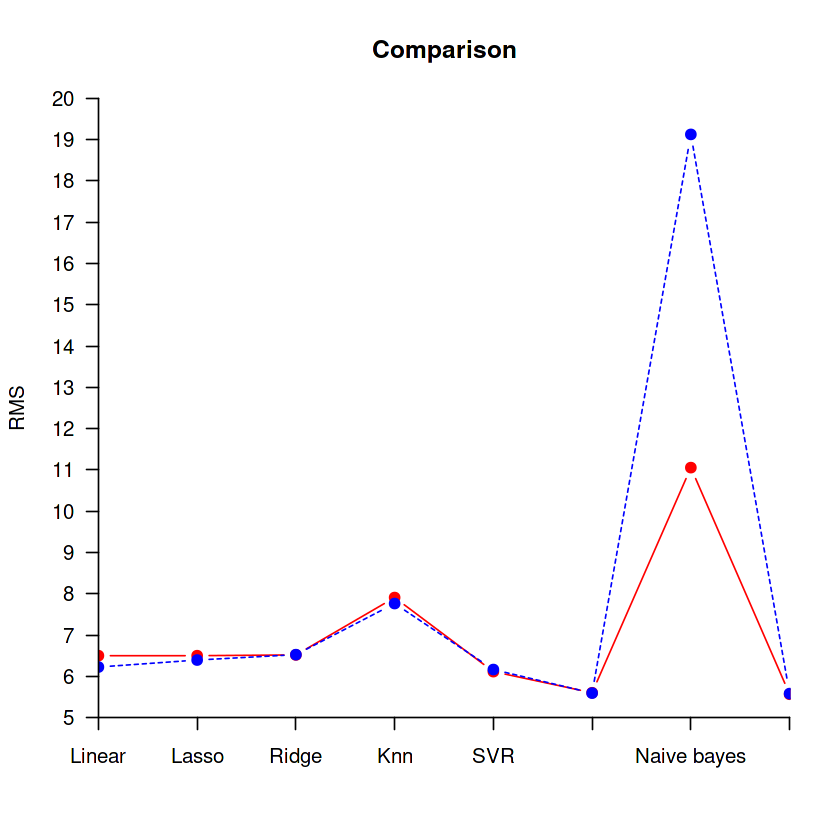

In [22]:
RMS1 <- c(r11,r12,r13,r14,r15,r16,r17,r18)
RMS2 <- c(r21,r22,r23,r24,r25,r26,r27,r28)
nm <- c("Linear","Lasso","Ridge","Knn","SVR","Random forest","Naive bayes","LightGbm")
dfr <- data.frame(RMS1,RMS2,nm)
View(dfr)
library(car)
plot(x=seq(nm), y=RMS1, type="b", lty=1,pch=19,col="red", ylim=c(5,20),
     axes=F, bty="n", xaxs="i", yaxs="i", main="Comparison",
     xlab="", ylab="RMS")
lines(x=seq(nm), y=RMS2, pch=19,type="b",col="blue",lty=2)
# add axes
axis(side=1, labels=nm, at=seq(nm))
axis(side=2, at=seq(5,20,1), las=1)

# add legend
par(xpd=TRUE)
legend(x=1.5, y=2, legend=c("RMS1", "RMS2"),col=c("red","blue"), lty=1:2, cex=.8,box.lty=0, ncol=2)
